In [1]:
import pandas as pd 
import numpy as np
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve, roc_auc_score
import seaborn as sns
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [2]:
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/NGULIM.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

In [3]:
train = pd.read_csv('../data/train_concat.csv')

ex1 = pd.read_excel('../data_0403/신촌.xlsx')

In [6]:
ex1.columns = ['FINAL', '(실명)등록번호', '연구등록번호', '외부', '병리작성일', '서식키', '병리번호', '병리진단',
       'Answer', 'age', 'sex', 'HTN', 'DM', 'plt', 'tpro', 'alb', 'Tchol',
       'bun', 'cr', 'eGFR', 'blood_dip', 'protein_dip', 'acr_urine',
       'pcr_urine', 'glu', 'glu_urine', 'esterase_urine', 'RBC', 'WBC',
       'Dysmorphic RBC[Random Urine]', 'G1 dysmorphic RBC[Random Urine]',
       'dysmorphism', 'RBC dysmorphism[Random Urine]']
ex1.columns

Index(['FINAL', '(실명)등록번호', '연구등록번호', '외부', '병리작성일', '서식키', '병리번호', '병리진단',
       'Answer', 'age', 'sex', 'HTN', 'DM', 'plt', 'tpro', 'alb', 'Tchol',
       'bun', 'cr', 'eGFR', 'blood_dip', 'protein_dip', 'acr_urine',
       'pcr_urine', 'glu', 'glu_urine', 'esterase_urine', 'RBC', 'WBC',
       'Dysmorphic RBC[Random Urine]', 'G1 dysmorphic RBC[Random Urine]',
       'dysmorphism', 'RBC dysmorphism[Random Urine]'],
      dtype='object')

In [7]:
ex_copy = ex1[['age', 'sex', 'HTN', 'DM', 'plt', 'alb',
       'bun', 'cr', 'eGFR', 'blood_dip', 'protein_dip',
       'acr_urine', 'pcr_urine', 'glu', 'RBC', 'WBC','Answer']].copy()
print(ex_copy.columns)
ex_copy.head()

Index(['age', 'sex', 'HTN', 'DM', 'plt', 'alb', 'bun', 'cr', 'eGFR',
       'blood_dip', 'protein_dip', 'acr_urine', 'pcr_urine', 'glu', 'RBC',
       'WBC', 'Answer'],
      dtype='object')


,age,sex,HTN,DM,plt,alb,bun,cr,eGFR,blood_dip,protein_dip,acr_urine,pcr_urine,glu,RBC,WBC,Answer
0,19,1,1,0,258,4.9,19.6,1.01,107.327123,2.0,0.5,0.012597,0.059629,90,10,2.0,1
1,41,2,1,0,318,3.3,9.0,1.05,65.916137,2.0,1.0,0.350500,1.012500,107,30,5.0,1
2,39,1,1,1,199,4.7,22.9,1.61,53.072129,2.0,0.5,11.109639,0.987952,222,30,2.0,1
3,53,2,1,0,277,3.5,22.5,0.94,69.261041,3.0,1.0,3.315789,0.977444,138,30,5.0,1
4,29,1,1,0,160,4.7,22.0,2.28,37.383786,2.0,1.0,5.356250,0.974265,123,30,2.0,1


In [8]:
print(train.shape)

print(ex_copy.shape)

(18513, 25)
(760, 17)


In [9]:
train_columns = set(train.columns)
ex1_columns = set(ex_copy.columns)

variable_difference = train_columns - ex1_columns
print(f"train 변수에서 validation 변수 제외한 변수들:{list(variable_difference)}")

train 변수에서 validation 변수 제외한 변수들:['WBC_binary', 'RBC_re', 'target', 'tpro', 'esterase_urine', 'glu_urine', 'WBC_re', 'esterase_binary', 'group', 'RBC_binary', 'dysmorphism']


In [10]:
train.columns = ['age', 'sex', 'HTN', 'DM', 'plt', 'tpro', 'alb', 'bun', 'cr', 'eGFR',
       'blood_dip', 'protein_dip', 'acr_urine', 'pcr_urine', 'glu',
       'glu_urine', 'esterase_urine', 'dysmorphism', 'RBC', 'WBC',
       'RBC_binary', 'WBC_binary', 'esterase_binary', 'group', 'target']

train.columns

Index(['age', 'sex', 'HTN', 'DM', 'plt', 'tpro', 'alb', 'bun', 'cr', 'eGFR',
       'blood_dip', 'protein_dip', 'acr_urine', 'pcr_urine', 'glu',
       'glu_urine', 'esterase_urine', 'dysmorphism', 'RBC', 'WBC',
       'RBC_binary', 'WBC_binary', 'esterase_binary', 'group', 'target'],
      dtype='object')

In [11]:
print(ex_copy['WBC'].value_counts())
ex_copy['RBC'].value_counts()

WBC
2.0     340
5.0     229
10.0     74
30.0     63
20.0     41
0.0      10
0.5       1
0.6       1
18.8      1
Name: count, dtype: int64


RBC
30    437
0      96
20     90
5      71
10     63
1       1
11      1
3       1
Name: count, dtype: int64

In [14]:
test = ex_copy.drop(['Answer'], axis=1).copy()
test.head()

,age,sex,HTN,DM,plt,alb,bun,cr,eGFR,blood_dip,protein_dip,acr_urine,pcr_urine,glu,RBC,WBC
0,19,1,1,0,258,4.9,19.6,1.01,107.327123,2.0,0.5,0.012597,0.059629,90,10,2.0
1,41,2,1,0,318,3.3,9.0,1.05,65.916137,2.0,1.0,0.350500,1.012500,107,30,5.0
2,39,1,1,1,199,4.7,22.9,1.61,53.072129,2.0,0.5,11.109639,0.987952,222,30,2.0
3,53,2,1,0,277,3.5,22.5,0.94,69.261041,3.0,1.0,3.315789,0.977444,138,30,5.0
4,29,1,1,0,160,4.7,22.0,2.28,37.383786,2.0,1.0,5.356250,0.974265,123,30,2.0


## Modeling_Biopsy

In [15]:
xgb = XGBClassifier(random_state = 2023, n_jobs=-1)

In [16]:
print(test.columns)
print(train.columns)

Index(['age', 'sex', 'HTN', 'DM', 'plt', 'alb', 'bun', 'cr', 'eGFR',
       'blood_dip', 'protein_dip', 'acr_urine', 'pcr_urine', 'glu', 'RBC',
       'WBC'],
      dtype='object')
Index(['age', 'sex', 'HTN', 'DM', 'plt', 'tpro', 'alb', 'bun', 'cr', 'eGFR',
       'blood_dip', 'protein_dip', 'acr_urine', 'pcr_urine', 'glu',
       'glu_urine', 'esterase_urine', 'dysmorphism', 'RBC', 'WBC',
       'RBC_binary', 'WBC_binary', 'esterase_binary', 'group', 'target'],
      dtype='object')


In [17]:
column_difference = set(ex_copy.columns).difference(set(train.columns))
print(f'val - train:{column_difference}')

column_difference = set(train.columns).difference(set(ex_copy.columns))
print(f'train - val:{column_difference}')

val - train:{'Answer'}
train - val:{'WBC_binary', 'target', 'tpro', 'esterase_urine', 'glu_urine', 'esterase_binary', 'group', 'RBC_binary', 'dysmorphism'}


In [18]:
X_train = train.drop(['WBC_binary', 'target', 'tpro', 'esterase_urine', 'glu_urine',
                       'esterase_binary', 'group', 'RBC_binary', 'dysmorphism'], axis=1).copy()
y_train = train['target'].copy()

In [19]:
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=-1,
              num_parallel_tree=None, random_state=2023, ...)

### test

In [20]:
test_pred = xgb.predict(test)
test_pred_prob = xgb.predict_proba(test)

In [21]:
ex_copy['pred'] = test_pred
ex_copy['pred_prob'] = test_pred_prob[:,1]

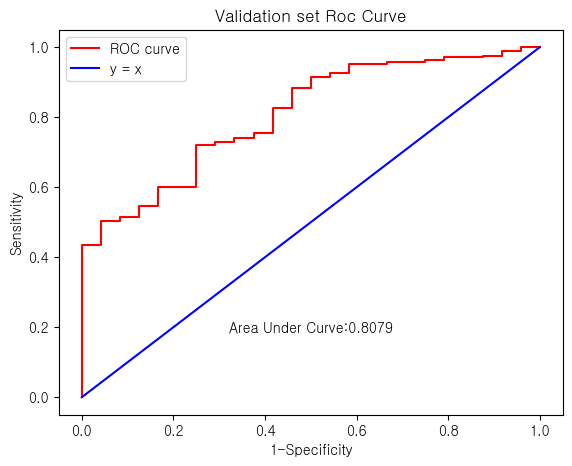

In [23]:
# roc curve, auc validation set
fpr, tpr, thresholds = roc_curve(np.array(ex_copy['Answer']), test_pred_prob[:,1])

plt.figure(figsize=(6.5, 5))
plt.plot(fpr, tpr, color = 'red', label = 'ROC curve')
plt.plot([0, 1], [0, 1], color = 'blue', label = 'y = x') # y = x 직선 표시

auc = roc_auc_score(np.array(ex_copy['Answer']), test_pred_prob[:,1])
plt.text(0.5, 0.2, f"Area Under Curve:{auc:.4f}", ha='center', va='center', fontsize=10)

plt.title('Validation set Roc Curve')
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])

plt.legend() # 그래프 라벨 표시

plt.show()

In [24]:
accuracy = accuracy_score(ex_copy['Answer'], test_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 42.11%


In [25]:
print(classification_report(ex_copy['Answer'], test_pred))

              precision    recall  f1-score   support

           0       0.05      1.00      0.10        24
           1       1.00      0.40      0.57       736

    accuracy                           0.42       760
   macro avg       0.53      0.70      0.34       760
weighted avg       0.97      0.42      0.56       760



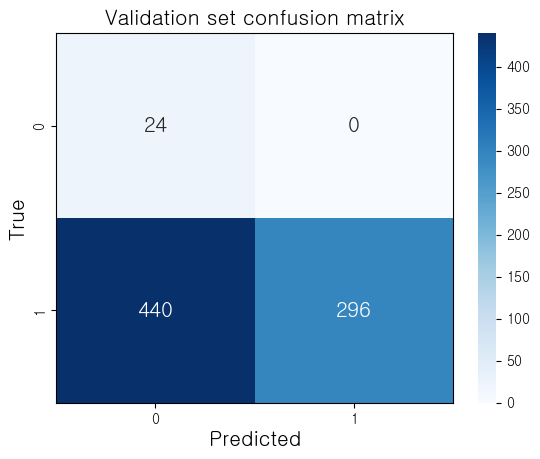

In [26]:
cm = confusion_matrix(ex_copy['Answer'], test_pred)

# Plot the confusion matrix with specific formatting for annotations
heatmap = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

# Accessing the text elements of the heatmap and setting font properties
for _, spine in heatmap.spines.items():
    spine.set_visible(True)

for t in heatmap.texts:
    t.set_fontsize(15)  # Set the font size here

plt.title('Validation set confusion matrix', fontsize = 15)
plt.xlabel('Predicted', fontsize=15)
plt.ylabel('True', fontsize=15)
plt.show()

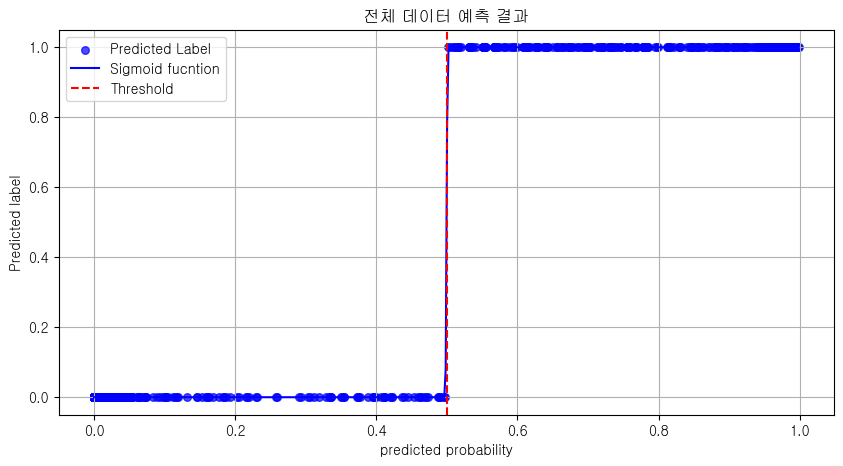

In [31]:
from scipy.interpolate import PchipInterpolator

# 데이터 포인트를 예측 확률에 따라 정렬
sorted_indices = np.argsort(test_pred_prob[:,1])
sorted_ex_copy_pred_prob = test_pred_prob[:,1][sorted_indices]
sorted_ex_copy_pred = test_pred[sorted_indices]

# x와 y를 튜플로 묶고 x를 기준으로 정렬
sorted_pairs = sorted(zip(sorted_ex_copy_pred_prob, sorted_ex_copy_pred))

# 정렬된 x와 y를 다시 분리
sorted_ex_copy_pred_prob, sorted_ex_copy_pred = zip(*sorted_pairs)

# 동일한 x 값에 대한 y 값을 평균화
df = pd.DataFrame({'x': sorted_ex_copy_pred_prob, 'y': sorted_ex_copy_pred})
df = df.groupby('x', as_index=False).mean()

# PchipInterpolator를 사용하여 보간 객체 생성
f = PchipInterpolator(df['x'], df['y'])

# 보간 함수를 사용하여 곡선 생성을 위한 y 값 계산
x_new = np.linspace(min(df['x']), max(df['x']), 500)
y_smooth = f(x_new)

# 그래프 그리기
plt.figure(figsize=(10,5))
plt.scatter(test_pred_prob[:,1], test_pred, color='blue', label='Predicted Label', alpha=0.7, s=30)
plt.plot(x_new, y_smooth, color='blue', label='Sigmoid fucntion')

# 기타 그래프 설정
plt.axvline(x=0.5, color='red', linestyle='--', label='Threshold')
plt.xlabel('predicted probability')
plt.ylabel('Predicted label')
plt.title('전체 데이터 예측 결과')
plt.legend()
plt.grid(True)
plt.show()

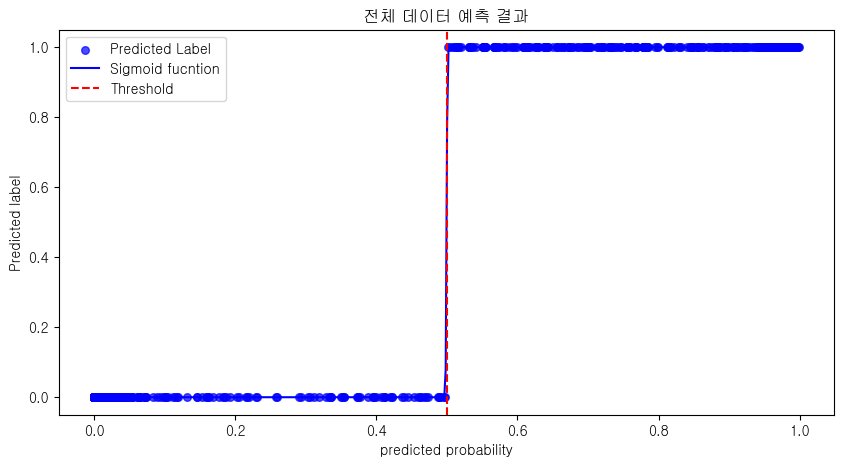

In [30]:
from scipy.interpolate import PchipInterpolator

# 데이터 포인트를 예측 확률에 따라 정렬
sorted_indices = np.argsort(test_pred_prob[:,1])
sorted_ex_copy_pred_prob = test_pred_prob[:,1][sorted_indices]
sorted_ex_copy_pred = test_pred[sorted_indices]

# x와 y를 튜플로 묶고 x를 기준으로 정렬
sorted_pairs = sorted(zip(sorted_ex_copy_pred_prob, sorted_ex_copy_pred))

# 정렬된 x와 y를 다시 분리
sorted_ex_copy_pred_prob, sorted_ex_copy_pred = zip(*sorted_pairs)

# 동일한 x 값에 대한 y 값을 평균화
df = pd.DataFrame({'x': sorted_ex_copy_pred_prob, 'y': sorted_ex_copy_pred})
df = df.groupby('x', as_index=False).mean()

# PchipInterpolator를 사용하여 보간 객체 생성
f = PchipInterpolator(df['x'], df['y'])

# 보간 함수를 사용하여 곡선 생성을 위한 y 값 계산
x_new = np.linspace(min(df['x']), max(df['x']), 500)
y_smooth = f(x_new)

# 그래프 그리기
plt.figure(figsize=(10,5))
plt.scatter(test_pred_prob[:,1], test_pred, color='blue', label='Predicted Label', alpha=0.7, s=30)
plt.plot(x_new, y_smooth, color='blue', label='Sigmoid fucntion')

# 기타 그래프 설정
plt.axvline(x=0.5, color='red', linestyle='--', label='Threshold')
plt.xlabel('predicted probability')
plt.ylabel('Predicted label')
plt.title('전체 데이터 예측 결과')
plt.legend()
plt.grid(False)
plt.show()

### 10% 중간 영역 제외

In [32]:
ex_copy.pred_prob.head()

0    0.001267
1    0.614551
2    0.064174
3    0.573653
4    0.956659
Name: pred_prob, dtype: float32

In [33]:
# 8개 제외됨
ex_copy_no_middle_10 = ex_copy[(ex_copy['pred_prob'] < 0.45) | (ex_copy['pred_prob'] > 0.55)].copy()
print(ex_copy_no_middle_10.shape)
ex_copy_no_middle_10.head()

(731, 19)


,age,sex,HTN,DM,plt,alb,bun,cr,eGFR,blood_dip,protein_dip,acr_urine,pcr_urine,glu,RBC,WBC,Answer,pred,pred_prob
0,19,1,1,0,258,4.9,19.6,1.01,107.327123,2.0,0.5,0.012597,0.059629,90,10,2.0,1,0,0.001267
1,41,2,1,0,318,3.3,9.0,1.05,65.916137,2.0,1.0,0.350500,1.012500,107,30,5.0,1,1,0.614551
2,39,1,1,1,199,4.7,22.9,1.61,53.072129,2.0,0.5,11.109639,0.987952,222,30,2.0,1,0,0.064174
3,53,2,1,0,277,3.5,22.5,0.94,69.261041,3.0,1.0,3.315789,0.977444,138,30,5.0,1,1,0.573653
4,29,1,1,0,160,4.7,22.0,2.28,37.383786,2.0,1.0,5.356250,0.974265,123,30,2.0,1,1,0.956659


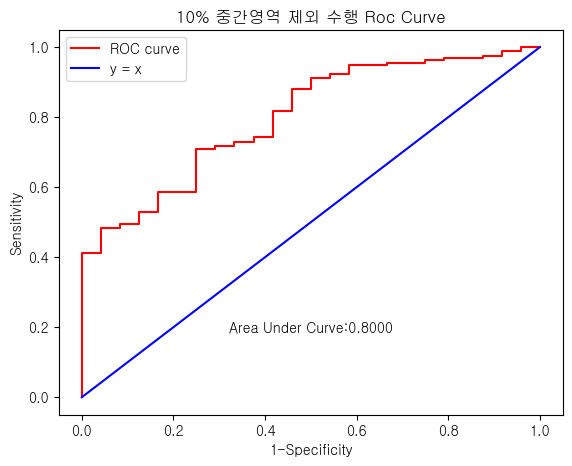

In [35]:
# roc curve, auc validation set
fpr, tpr, thresholds = roc_curve(np.array(ex_copy_no_middle_10['Answer']), ex_copy_no_middle_10['pred_prob'])

plt.figure(figsize=(6.5,5))

# auc 계산

plt.plot(fpr, tpr, color = 'red', label = 'ROC curve')
plt.plot([0, 1], [0, 1], color = 'blue', label = 'y = x') # y = x 직선 표시

auc = roc_auc_score(np.array(ex_copy_no_middle_10['Answer']), ex_copy_no_middle_10['pred_prob'])
plt.text(0.5, 0.2, f"Area Under Curve:{auc:.4f}", ha='center', va='center', fontsize=10)
plt.title('10% 중간영역 제외 수행 Roc Curve')
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')

plt.legend() # 그래프 라벨 표시

plt.show()

In [36]:
accuracy = accuracy_score(ex_copy_no_middle_10['Answer'], ex_copy_no_middle_10['pred'])
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 41.59%


In [37]:
print(classification_report(ex_copy_no_middle_10['Answer'], ex_copy_no_middle_10['pred']))

              precision    recall  f1-score   support

           0       0.05      1.00      0.10        24
           1       1.00      0.40      0.57       707

    accuracy                           0.42       731
   macro avg       0.53      0.70      0.33       731
weighted avg       0.97      0.42      0.55       731



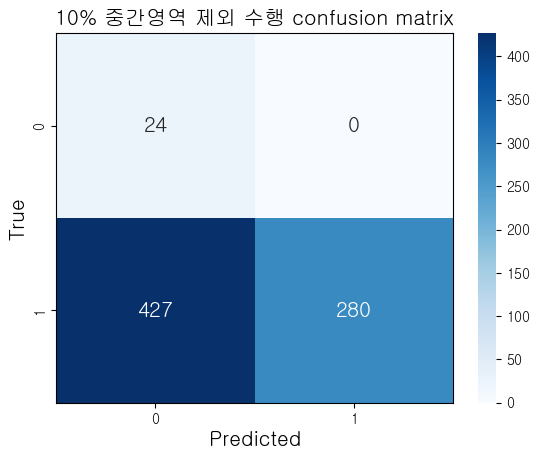

In [38]:
cm = confusion_matrix(ex_copy_no_middle_10['Answer'], ex_copy_no_middle_10['pred'])

# Plot the confusion matrix with specific formatting for annotations
heatmap = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

# Accessing the text elements of the heatmap and setting font properties
for _, spine in heatmap.spines.items():
    spine.set_visible(True)

for t in heatmap.texts:
    t.set_fontsize(15)  # Set the font size here

plt.title('10% 중간영역 제외 수행 confusion matrix', fontsize = 15)
plt.xlabel('Predicted', fontsize=15)
plt.ylabel('True', fontsize=15)
plt.show()

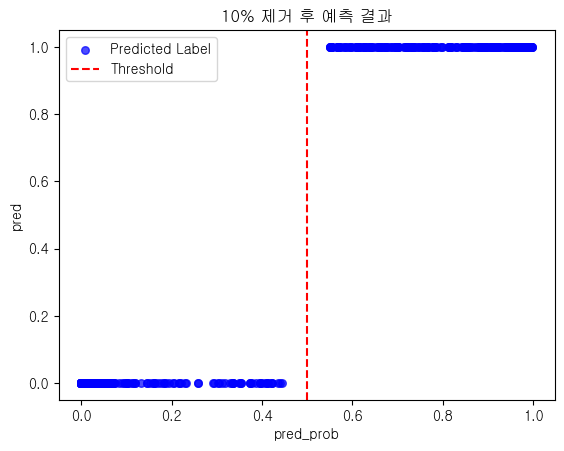

In [39]:
plt.scatter(ex_copy_no_middle_10['pred_prob'], ex_copy_no_middle_10['pred'], color='blue', label='Predicted Label', alpha=0.7, s=30)

# Add the sigmoid-shaped line at 0.5 threshold
plt.axvline(x=0.5, color='red', linestyle='--', label='Threshold')

plt.xlabel('pred_prob')
plt.ylabel('pred')
plt.title('10% 제거 후 예측 결과')
plt.legend()
plt.show()

In [40]:
middle_10_pred_prob = np.array(ex_copy_no_middle_10['pred_prob'])
middle_10_pred = np.array(ex_copy_no_middle_10['pred'])

print(len(middle_10_pred_prob))
print(len(ex_copy_no_middle_10['pred_prob']))

731
731


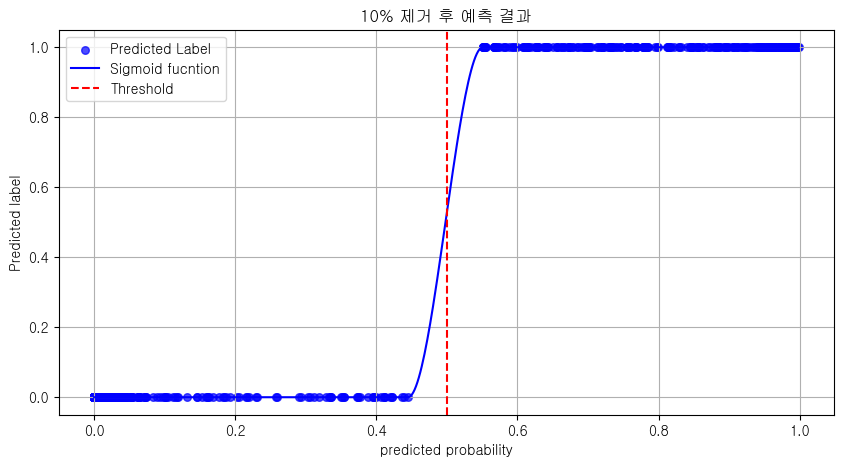

In [44]:
from scipy.interpolate import PchipInterpolator

# 데이터 포인트를 예측 확률에 따라 정렬
sorted_indices = np.argsort(middle_10_pred_prob)
sorted_ex_copy_pred_prob = middle_10_pred_prob[sorted_indices]
sorted_ex_copy_pred = middle_10_pred[sorted_indices]

# x와 y를 튜플로 묶고 x를 기준으로 정렬
sorted_pairs = sorted(zip(sorted_ex_copy_pred_prob, sorted_ex_copy_pred))

# 정렬된 x와 y를 다시 분리
sorted_ex_copy_pred_prob, sorted_ex_copy_pred = zip(*sorted_pairs)

# 동일한 x 값에 대한 y 값을 평균화
df = pd.DataFrame({'x': sorted_ex_copy_pred_prob, 'y': sorted_ex_copy_pred})
df = df.groupby('x', as_index=False).mean()

# PchipInterpolator를 사용하여 보간 객체 생성
f = PchipInterpolator(df['x'], df['y'])

# 보간 함수를 사용하여 곡선 생성을 위한 y 값 계산
x_new = np.linspace(min(df['x']), max(df['x']), 500)
y_smooth = f(x_new)

# 그래프 그리기
plt.figure(figsize=(10,5))
plt.scatter(middle_10_pred_prob, middle_10_pred, color='blue', label='Predicted Label', alpha=0.7, s=30)
plt.plot(x_new, y_smooth, color='blue', label='Sigmoid fucntion')

# 기타 그래프 설정
plt.axvline(x=0.5, color='red', linestyle='--', label='Threshold')
plt.xlabel('predicted probability')
plt.ylabel('Predicted label')
plt.title('10% 제거 후 예측 결과')
plt.legend()
plt.grid(True)
plt.show()

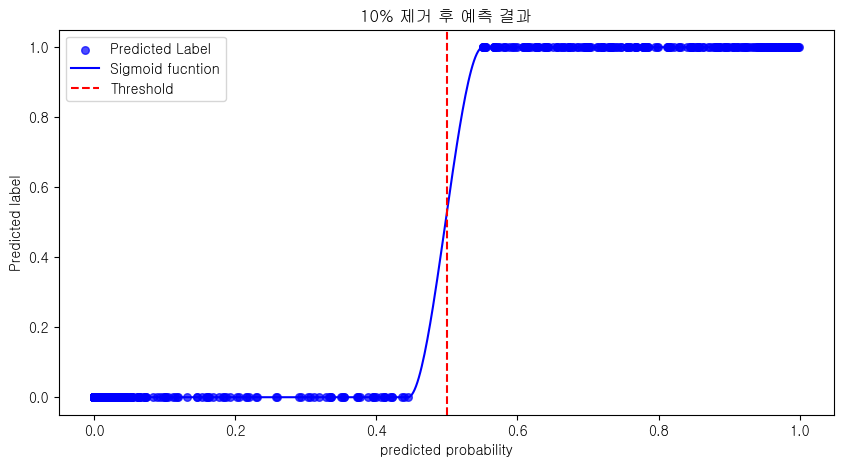

In [43]:
from scipy.interpolate import PchipInterpolator

# 데이터 포인트를 예측 확률에 따라 정렬
sorted_indices = np.argsort(middle_10_pred_prob)
sorted_ex_copy_pred_prob = middle_10_pred_prob[sorted_indices]
sorted_ex_copy_pred = middle_10_pred[sorted_indices]

# x와 y를 튜플로 묶고 x를 기준으로 정렬
sorted_pairs = sorted(zip(sorted_ex_copy_pred_prob, sorted_ex_copy_pred))

# 정렬된 x와 y를 다시 분리
sorted_ex_copy_pred_prob, sorted_ex_copy_pred = zip(*sorted_pairs)

# 동일한 x 값에 대한 y 값을 평균화
df = pd.DataFrame({'x': sorted_ex_copy_pred_prob, 'y': sorted_ex_copy_pred})
df = df.groupby('x', as_index=False).mean()

# PchipInterpolator를 사용하여 보간 객체 생성
f = PchipInterpolator(df['x'], df['y'])

# 보간 함수를 사용하여 곡선 생성을 위한 y 값 계산
x_new = np.linspace(min(df['x']), max(df['x']), 500)
y_smooth = f(x_new)

# 그래프 그리기
plt.figure(figsize=(10,5))
plt.scatter(middle_10_pred_prob, middle_10_pred, color='blue', label='Predicted Label', alpha=0.7, s=30)
plt.plot(x_new, y_smooth, color='blue', label='Sigmoid fucntion')

# 기타 그래프 설정
plt.axvline(x=0.5, color='red', linestyle='--', label='Threshold')
plt.xlabel('predicted probability')
plt.ylabel('Predicted label')
plt.title('10% 제거 후 예측 결과')
plt.legend()
plt.grid(False)
plt.show()

### 20% 중간 영역 제외

In [45]:
# 8개 제외됨
ex_copy_no_middle = ex_copy[(ex_copy['pred_prob'] < 0.4) | (ex_copy['pred_prob'] > 0.6)].copy()
print(ex_copy_no_middle.shape)
ex_copy_no_middle.head()

(695, 19)


,age,sex,HTN,DM,plt,alb,bun,cr,eGFR,blood_dip,protein_dip,acr_urine,pcr_urine,glu,RBC,WBC,Answer,pred,pred_prob
0,19,1,1,0,258,4.9,19.6,1.01,107.327123,2.0,0.5,0.012597,0.059629,90,10,2.0,1,0,0.001267
1,41,2,1,0,318,3.3,9.0,1.05,65.916137,2.0,1.0,0.350500,1.012500,107,30,5.0,1,1,0.614551
2,39,1,1,1,199,4.7,22.9,1.61,53.072129,2.0,0.5,11.109639,0.987952,222,30,2.0,1,0,0.064174
4,29,1,1,0,160,4.7,22.0,2.28,37.383786,2.0,1.0,5.356250,0.974265,123,30,2.0,1,1,0.956659
5,43,2,1,0,295,4.6,15.7,0.67,107.657235,1.0,0.0,0.035714,0.102484,103,10,2.0,1,0,0.000029


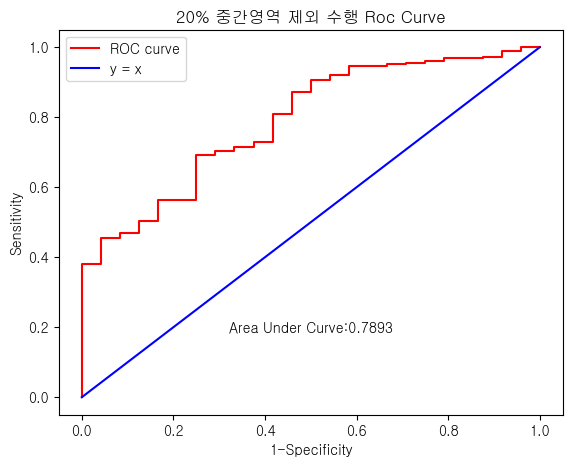

In [46]:
# roc curve, auc validation set
fpr, tpr, thresholds = roc_curve(np.array(ex_copy_no_middle['Answer']), ex_copy_no_middle['pred_prob'])

plt.figure(figsize=(6.5,5))

# auc 계산
plt.plot(fpr, tpr, color = 'red', label = 'ROC curve')
plt.plot([0, 1], [0, 1], color = 'blue', label = 'y = x') # y = x 직선 표시

auc = roc_auc_score(np.array(ex_copy_no_middle['Answer']), ex_copy_no_middle['pred_prob'])
plt.text(0.5, 0.2, f"Area Under Curve:{auc:.4f}", ha='center', va='center', fontsize=10)
plt.title('20% 중간영역 제외 수행 Roc Curve')
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')

plt.legend() # 그래프 라벨 표시

plt.show()

In [47]:
accuracy = accuracy_score(ex_copy_no_middle['Answer'], ex_copy_no_middle['pred'])
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 40.14%


In [48]:
print(classification_report(ex_copy_no_middle['Answer'], ex_copy_no_middle['pred']))

              precision    recall  f1-score   support

           0       0.05      1.00      0.10        24
           1       1.00      0.38      0.55       671

    accuracy                           0.40       695
   macro avg       0.53      0.69      0.33       695
weighted avg       0.97      0.40      0.54       695



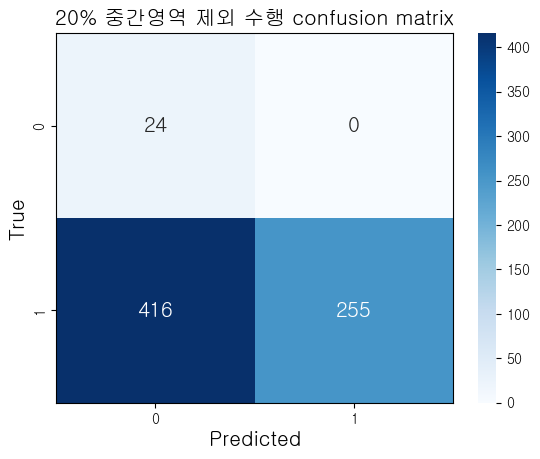

In [50]:
cm = confusion_matrix(ex_copy_no_middle['Answer'], ex_copy_no_middle['pred'])

# Plot the confusion matrix with specific formatting for annotations
heatmap = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

# Accessing the text elements of the heatmap and setting font properties
for _, spine in heatmap.spines.items():
    spine.set_visible(True)

for t in heatmap.texts:
    t.set_fontsize(15)  # Set the font size here

plt.title('20% 중간영역 제외 수행 confusion matrix', fontsize = 15)
plt.xlabel('Predicted', fontsize=15)
plt.ylabel('True', fontsize=15)
plt.show()

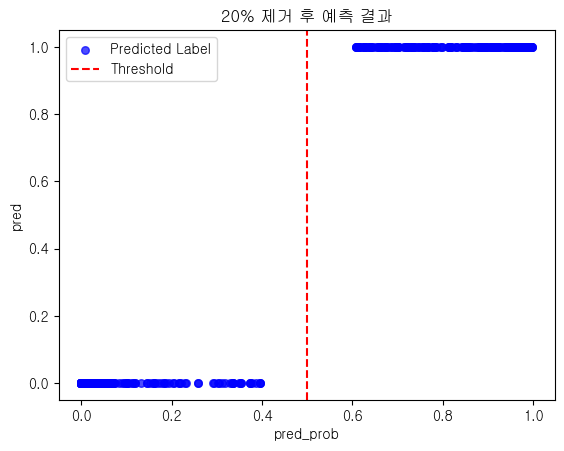

In [51]:
plt.scatter(ex_copy_no_middle['pred_prob'], ex_copy_no_middle['pred'], color='blue', label='Predicted Label', alpha=0.7, s=30)

# Add the sigmoid-shaped line at 0.5 threshold
plt.axvline(x=0.5, color='red', linestyle='--', label='Threshold')

plt.xlabel('pred_prob')
plt.ylabel('pred')
plt.title('20% 제거 후 예측 결과')
plt.legend()
plt.show()

In [52]:
middle_pred_prob = np.array(ex_copy_no_middle['pred_prob'])
middle_pred = np.array(ex_copy_no_middle['pred'])

print(len(middle_pred_prob))
print(len(ex_copy_no_middle['pred_prob']))

695
695


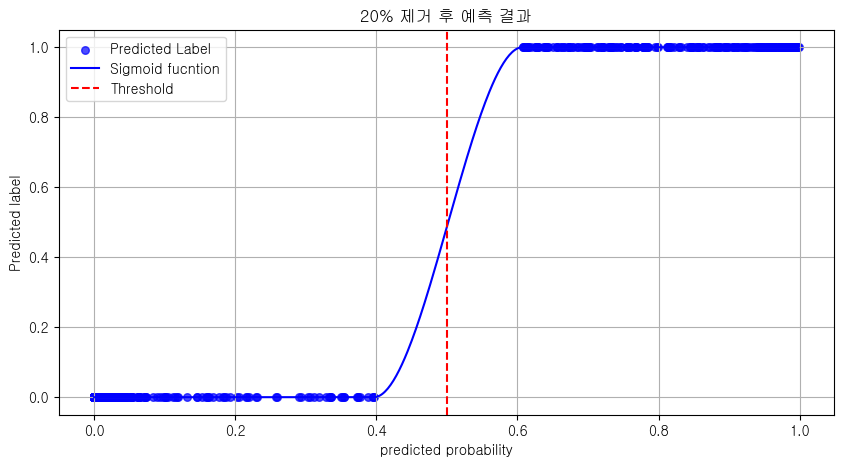

In [55]:
from scipy.interpolate import PchipInterpolator

# 데이터 포인트를 예측 확률에 따라 정렬
sorted_indices = np.argsort(middle_pred_prob)
sorted_ex_copy_pred_prob = middle_pred_prob[sorted_indices]
sorted_ex_copy_pred = middle_pred[sorted_indices]

# x와 y를 튜플로 묶고 x를 기준으로 정렬
sorted_pairs = sorted(zip(sorted_ex_copy_pred_prob, sorted_ex_copy_pred))

# 정렬된 x와 y를 다시 분리
sorted_ex_copy_pred_prob, sorted_ex_copy_pred = zip(*sorted_pairs)

# 동일한 x 값에 대한 y 값을 평균화
df = pd.DataFrame({'x': sorted_ex_copy_pred_prob, 'y': sorted_ex_copy_pred})
df = df.groupby('x', as_index=False).mean()

# PchipInterpolator를 사용하여 보간 객체 생성
f = PchipInterpolator(df['x'], df['y'])

# 보간 함수를 사용하여 곡선 생성을 위한 y 값 계산
x_new = np.linspace(min(df['x']), max(df['x']), 500)
y_smooth = f(x_new)

# 그래프 그리기
plt.figure(figsize=(10,5))
plt.scatter(middle_pred_prob, middle_pred, color='blue', label='Predicted Label', alpha=0.7, s=30)
plt.plot(x_new, y_smooth, color='blue', label='Sigmoid fucntion')

# 기타 그래프 설정
plt.axvline(x=0.5, color='red', linestyle='--', label='Threshold')
plt.xlabel('predicted probability')
plt.ylabel('Predicted label')
plt.title('20% 제거 후 예측 결과')
plt.legend()
plt.grid(True)
plt.show()

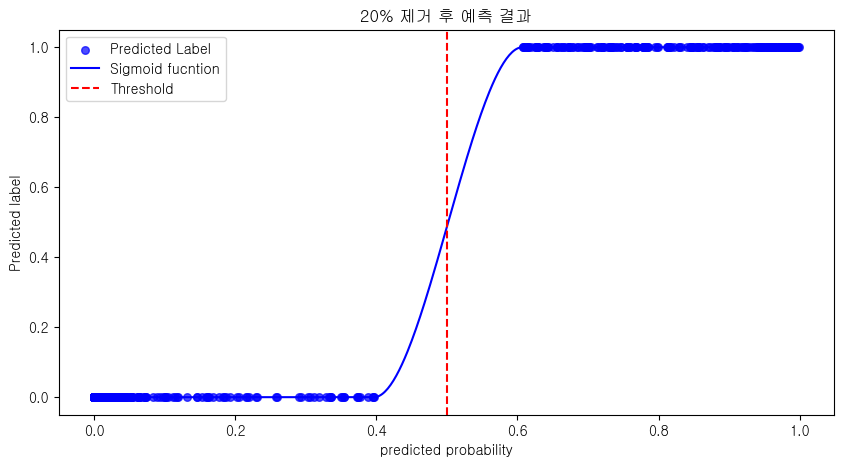

In [54]:
from scipy.interpolate import PchipInterpolator

# 데이터 포인트를 예측 확률에 따라 정렬
sorted_indices = np.argsort(middle_pred_prob)
sorted_ex_copy_pred_prob = middle_pred_prob[sorted_indices]
sorted_ex_copy_pred = middle_pred[sorted_indices]

# x와 y를 튜플로 묶고 x를 기준으로 정렬
sorted_pairs = sorted(zip(sorted_ex_copy_pred_prob, sorted_ex_copy_pred))

# 정렬된 x와 y를 다시 분리
sorted_ex_copy_pred_prob, sorted_ex_copy_pred = zip(*sorted_pairs)

# 동일한 x 값에 대한 y 값을 평균화
df = pd.DataFrame({'x': sorted_ex_copy_pred_prob, 'y': sorted_ex_copy_pred})
df = df.groupby('x', as_index=False).mean()

# PchipInterpolator를 사용하여 보간 객체 생성
f = PchipInterpolator(df['x'], df['y'])

# 보간 함수를 사용하여 곡선 생성을 위한 y 값 계산
x_new = np.linspace(min(df['x']), max(df['x']), 500)
y_smooth = f(x_new)

# 그래프 그리기
plt.figure(figsize=(10,5))
plt.scatter(middle_pred_prob, middle_pred, color='blue', label='Predicted Label', alpha=0.7, s=30)
plt.plot(x_new, y_smooth, color='blue', label='Sigmoid fucntion')

# 기타 그래프 설정
plt.axvline(x=0.5, color='red', linestyle='--', label='Threshold')
plt.xlabel('predicted probability')
plt.ylabel('Predicted label')
plt.title('20% 제거 후 예측 결과')
plt.legend()
plt.grid(False)
plt.show()